# Classification on IMDB Reviews Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection


# Task 1: Data Preprocessing

## Importing the first dataset: IMDB Reviews

Download the IMDB Reviews from https://ai.stanford.edu/%7Eamaas/data/sentiment/

In [ ]:
# uploading the data gz folder
from google.colab import files
uploaded = files.upload()

Saving aclImdb_v1.tar.gz to aclImdb_v1.tar.gz


In [ ]:
file = tarfile.open("aclImdb_v1.tar.gz")

In [ ]:
file.extractall()

Read the vocabulary

In [ ]:
from numpy import loadtxt
vocabulary = loadtxt('/content/aclImdb/imdb.vocab', dtype='str')
vocabulary

array(['the', 'and', 'a', ..., 'kinky-sex', 'urrrghhh',
       'investigator-like'], dtype='<U76')

Read ratings of each movie (y) and BoW features (X)

In [ ]:
file = '/content/aclImdb/train/labeledBow.feat'

In [ ]:
import sklearn.datasets
X,y = sklearn.datasets.load_svmlight_file(file, dtype= 'uint8')

## Reduce space

Reduce space ---> Filter out irrelevant words:

Drop words that appear in less than 1% (rare words) and in more than 50% (stopwords) of the documents.

First determine in how many documents each word appeared.

In [ ]:
# Count in how many documents each word appears
doc_counts = np.array((X > 0).sum(axis=0)).flatten()

# Compute document frequency (proportion)
doc_freqs = doc_counts / X.shape[0]

# Filter mask: words appearing in >1% and ≤50% of documents
mask = (doc_freqs > 0.01) & (doc_freqs <= 0.5)

# Apply mask to vocabulary and counts
filtered_words = np.array(vocabulary)[mask]
filtered_counts = doc_counts[mask]

# Create dataframe of filtered words
freq_df = pd.DataFrame({
    'Word': filtered_words,
    'Doc_Count': filtered_counts
})

freq_df

,Word,Doc_Count
0,he,10308
1,his,10677
2,!,8595
3,by,11689
4,an,12203
...,...,...
1729,portray,252
1730,discovered,251
1731,aware,253
1732,continues,252


Create the final dataframe

In [ ]:
import scipy.sparse

# Map words to indices and reverse
vocab_dict = {word: idx for idx, word in enumerate(vocabulary)}
vocab_dict2 = {idx: word for word, idx in vocab_dict.items()}

# Get feature indices for filtered words
features = [vocab_dict[word] for word in freq_df['Word'] if word in vocab_dict]

# Create DataFrame from sparse matrix with selected columns
final_df = pd.DataFrame.sparse.from_spmatrix(X[:, features])

# Rename columns using vocab_dict2
final_df.columns = [vocab_dict2[i] for i in features]

# Add target labels (y should have the same number of rows as X)
final_df = pd.concat([final_df, pd.Series(y, name='Rate')], axis=1)


In [ ]:
final_df

,he,his,!,by,an,who,they,from,so,like,...,noticed,discover,opposite,prove,portray,discovered,aware,continues,below,Rate
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
1,0,0,1,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,7.0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9.0
3,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,10.0
4,0,0,0,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,5,0,9,3,1,7,3,2,1,0,...,0,0,0,0,0,0,0,0,1,1.0
24996,2,2,1,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1.0
24997,0,2,0,2,1,2,3,1,0,3,...,0,0,0,0,0,0,0,0,0,4.0
24998,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0


## Feature importance with z-score

In [ ]:

from sklearn.preprocessing import StandardScaler

# Standardize features
xnormal = final_df.drop('Rate', axis=1).to_numpy()
xstand = StandardScaler().fit_transform(xnormal)

# Standardize target
ynormal = final_df['Rate'].to_numpy().reshape(-1, 1)
ystand = StandardScaler().fit_transform(ynormal).flatten()

# Compute z-scores (dot product between each feature and standardized target)
z_scores = np.dot(xstand.T, ystand) / np.sqrt(xstand.shape[0])

# Build DataFrame
scoredf = pd.DataFrame({
    'Word': final_df.columns[:-1],  # all except 'Rate'
    'Z-score': z_scores
})


In [ ]:
# Rank features by absolute z-score
scoredf['Abs_Z'] = scoredf['Z-score'].abs()
scoredf_sorted = scoredf.sort_values(by='Abs_Z', ascending=False)

# Select top D features (D = 300)
D = 150 # (150 positive and 150 negative words)
top_features = scoredf_sorted.head(D)

# Top positive and negative features
top_positive = scoredf.sort_values(by='Z-score', ascending=False).head(D)
top_negative = scoredf.sort_values(by='Z-score', ascending=True).head(D)

print("Top positive features (good reviews):")
print(top_positive)

print("\nTop negative features (bad reviews):")
print(top_negative)


Top positive features (good reviews):
            Word    Z-score      Abs_Z
56         great  32.062833  32.062833
342    wonderful  25.661437  25.661437
282    excellent  25.268965  25.268965
88          best  24.739246  24.739246
87          love  20.545087  20.545087
...          ...        ...        ...
544          age   7.136797   7.136797
807   believable   7.126350   7.126350
1346   available   7.119286   7.119286
59           him   7.118068   7.118068
146           us   7.108560   7.108560

[150 rows x 3 columns]

Top negative features (bad reviews):
          Word    Z-score      Abs_Z
50         bad -42.995039  42.995039
213      worst -41.419351  41.419351
400      waste -33.466558  33.466558
341      awful -30.743631  30.743631
19           ? -27.427788  27.427788
..         ...        ...        ...
493  obviously  -8.204250   8.204250
286       else  -8.186326   8.186326
739      tried  -8.141801   8.141801
40        were  -8.128126   8.128126
239      maybe  -8.020167

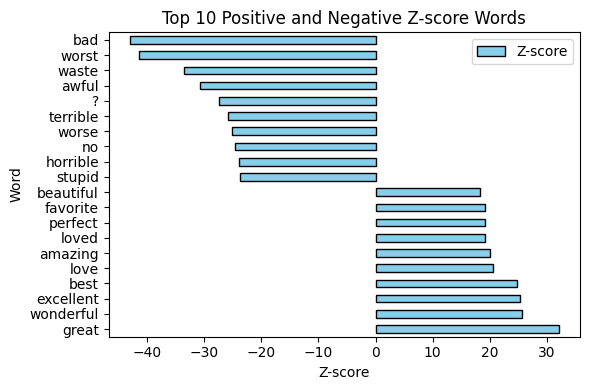

In [ ]:
import matplotlib.pyplot as plt

# Sort features by Z-score
plot = scoredf.drop(['Abs_Z'], axis = 1).sort_values(by='Z-score', ascending=False)

# Select top 10 positive and top 10 negative Z-score features
top_pos = plot.head(10)
top_neg = plot.tail(10)

# Combine and plot
plot2 = pd.concat([top_pos, top_neg])
plot2.set_index('Word', inplace=True)

# Plot horizontal bar chart
ax = plot2.plot.barh(figsize=(6, 4), color='skyblue', edgecolor='black')
ax.set_title('Top 10 Positive and Negative Z-score Words')
ax.set_xlabel('Z-score')
plt.tight_layout()
plt.show()


In [ ]:
IMDB_feature = pd.concat([top_positive, top_negative]).drop(['Z-score', 'Abs_Z'], axis = 1)
IMDB_feature

,Word
56,great
342,wonderful
282,excellent
88,best
87,love
...,...
493,obviously
286,else
739,tried
40,were


In [ ]:
# Get the list of selected feature names
selected_words = IMDB_feature['Word'].tolist()

# Extract those columns + 'Rate' column from the full DataFrame
subset_df = final_df[selected_words + ['Rate']]
subset_df

,great,wonderful,excellent,best,love,amazing,loved,perfect,favorite,beautiful,...,premise,ugly,trying,cliché,obviously,else,tried,were,maybe,Rate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,9.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
4,1,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
24996,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.0
24998,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0


## Train Set IMDB

In [ ]:
# Features
X_train_IMDB = subset_df.drop('Rate', axis=1)

# Target
y_train_IMDB = (subset_df['Rate']  >= 7).astype(int)  # Binary target

## Test Set IMDB

In [ ]:
#For the test data
file = '/content/aclImdb/test/labeledBow.feat'
X,y = sklearn.datasets.load_svmlight_file(file, dtype= 'uint8')

In [ ]:
# Create DataFrame from sparse matrix with selected columns
final_test_df = pd.DataFrame.sparse.from_spmatrix(X[:, features])

# Rename columns using vocab_dict2
final_test_df.columns = [vocab_dict2[i] for i in features]

# Add target labels (y should have the same number of rows as X)
final_test_df = pd.concat([final_test_df, pd.Series(y, name='Rate')], axis=1)

# Extract those columns (selected words) + 'Rate' column from the full test DataFrame
test_df_IMDB = final_test_df[selected_words + ['Rate']]

# Features
X_test_IMDB = test_df_IMDB.drop('Rate', axis=1)

# Target
y_test_IMDB = (test_df_IMDB['Rate'] >= 7).astype(int)  # Binary target

test_df_IMDB

,great,wonderful,excellent,best,love,amazing,loved,perfect,favorite,beautiful,...,premise,ugly,trying,cliché,obviously,else,tried,were,maybe,Rate
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,10.0
1,2,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
2,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,3,1,7.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,1,7.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
24997,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4.0
24998,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


# Task 2: Implementing Logistic Regression, KNN and Random Forest

## Cross-validation to find the best model parameters

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grids for each model
param_grid = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [10, 50],
        'model__max_depth': [None, 5]
    },
    {
        'model': [LogisticRegression()],
        'model__C': [0.01, 0.1],
        'model__solver': ['liblinear']
    },
    {
         'model': [KNeighborsClassifier()],
         'model__n_neighbors': [10]
    },
    ]

pipeline = Pipeline([('model', RandomForestClassifier())])
# Perform Grid Search over multiple estimators
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to your data
grid_search.fit(X_train_IMDB, y_train_IMDB)

# Print best model and hyperparameters
print("Best Model:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)
print(grid_search.best_score_)


# Get the cross-validation results
cv_results = grid_search.cv_results_

# Extract the model names and corresponding accuracy
for i in range(len(cv_results['mean_test_score'])):
    print(f"Model: {cv_results['params'][i]}")
    print(f"Accuracy: {100*cv_results['mean_test_score'][i]:.4f} and std: {100* cv_results['std_test_score'][i]:.4f}")
    print("-" * 40)


Best Model: Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
Best Parameters: {'model': LogisticRegression(), 'model__C': 0.1, 'model__solver': 'liblinear'}
0.8568
Model: {'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 10}
Accuracy: 78.2240 and std: 1.0318
----------------------------------------
Model: {'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 50}
Accuracy: 82.0720 and std: 1.1976
----------------------------------------
Model: {'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__n_estimators': 10}
Accuracy: 74.3200 and std: 1.5433
----------------------------------------
Model: {'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__n_estimators': 50}
Accuracy: 77.5480 and std: 1.3244
----------------------------------------
Model: {'model': LogisticRegression(), 'model__C': 0.01, 'model__solver': 'liblinear'}
Accuracy: 85.2000 and std: 0.8287
-----------

# Task 3: Predictions and Comparison with ROC

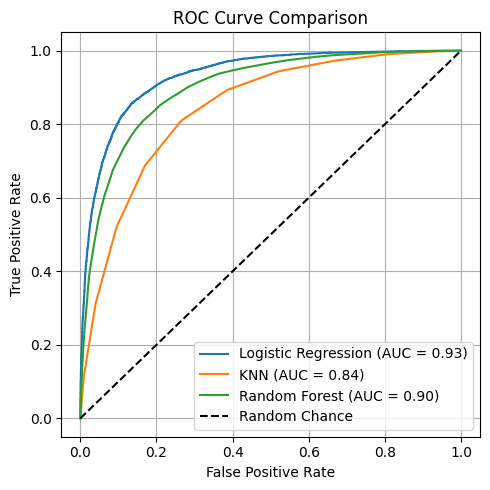

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

models = {
    'Logistic Regression': make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(C=0.1, solver='liblinear')
    ),
    'KNN': make_pipeline(
        StandardScaler(with_mean=False),
        KNeighborsClassifier(n_neighbors=10)
    ),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=None)
}

plt.figure(figsize=(5, 5))

for name, model in models.items():
    model.fit(X_train_IMDB, y_train_IMDB)

    # Get predicted probabilities (for class 1)
    y_proba = model.predict_proba(X_test_IMDB)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_IMDB, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
